In [39]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import datetime
import math
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.decomposition import PCA

In [40]:
from tensorflow.keras import mixed_precision

# # Set the global policy to mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [41]:
# import os

# # Set the environment variable
# os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [42]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [43]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


I0000 00:00:1730118380.267949   13720 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730118380.270971   13720 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730118380.273103   13720 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730118380.275229   13720 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [44]:
# data = pd.read_csv("C:\Users\alanx\OneDrive - The University of Sydney (Students)\Thesis\Deep Learning\wifi_localization\data\csv\ultimate_combined.csv")
# data = pd.read_csv("data/csv/ultimate_combined.csv")
data = pd.read_csv("data/csv/still/still.csv")
# data = pd.read_csv("data/csv/still_with_receiver/still_with_receiver.csv")

data.head()

,timestamps,csi_len,channel,err_info,noise_floor,rate,bandWidth,num_tones,nr,nc,...,subcarriers,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,with_receiver,coord1,coord2,ant1_amplitude_cluster,ant2_amplitude_cluster
0,3689776957,280,2437,0,0,135,0,56,2,1,...,2,0.792823,1.803142,0.766030,0.970214,0,5,3,0.0,2.0
1,3689776957,280,2437,0,0,135,0,56,2,1,...,5,0.633937,1.881858,0.718191,0.925932,0,5,3,0.0,2.0
2,3689776957,280,2437,0,0,135,0,56,2,1,...,6,0.415493,1.937205,0.687843,0.903455,0,5,3,0.0,2.0
3,3689776957,280,2437,0,0,135,0,56,2,1,...,7,0.165612,1.719851,0.707981,0.922570,0,5,3,0.0,2.0
4,3689776957,280,2437,0,0,135,0,56,2,1,...,8,-0.153431,1.705586,0.696637,0.922810,0,5,3,0.0,2.0


In [45]:
# data.drop('with_receiver', axis=1, inplace=True)
# data.drop('nc', axis=1, inplace=True)
# data.drop('ant1_phase', axis=1, inplace=True)
# data.drop('ant2_phase', axis=1, inplace=True)

In [46]:
# data = pd.concat([data, pd.get_dummies(data['subcarriers'], prefix='subcarrier')], axis=1)
# data.drop('rssi', axis=1, inplace=True)
# data.drop('rssi1', axis=1, inplace=True)
# data.drop('rssi2', axis=1, inplace=True)
# data.drop('rssi3', axis=1, inplace=True)
# data.head()
amplitudes_subcarriers = data[['ant1_amplitude', 'ant2_amplitude', 'subcarriers']]
data.drop(columns=["timestamps", 'ant1_amplitude', 'ant2_amplitude', 'subcarriers'], axis=1, inplace=True)

In [47]:
# features_scaled = ["ant1_phase", "ant2_phase", "rssi", "rssi1", "rssi2"]

In [48]:
features_scaled = ["ant1_phase", "ant2_phase", "rssi", "rssi1", "rssi2"]
features = data.columns
# X = data.drop(columns=['coord1', 'coord2', 'ant1_amplitude', 'ant2_amplitude'])
X = data.drop(columns=['coord1', 'coord2'])
y = data[['coord1', 'coord2']]

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = X

# Separate the columns that need to be scaled
columns_to_scale = [col for col in X.columns if col not in features_scaled]

# Initialize the scaler
scaler = StandardScaler()

# Apply the scaler to the columns that need to be scaled
X_scaled_part = scaler.fit_transform(X[columns_to_scale])

# Create a DataFrame for the scaled part, with the correct column names
X_scaled_df = pd.DataFrame(X_scaled_part, columns=columns_to_scale)

# Combine the scaled columns with the unscaled columns
X_scaled = pd.concat([X_scaled_df, X[features_scaled]], axis=1)

# Reorder columns to match the original DataFrame's structure (optional)
X_scaled = X_scaled[X.columns]

X_scaled.head()

,csi_len,channel,err_info,noise_floor,rate,bandWidth,num_tones,nr,nc,rssi,rssi1,rssi2,rssi3,payload_length,block_length,ant1_phase,ant2_phase,with_receiver,ant1_amplitude_cluster,ant2_amplitude_cluster
0,-2.537797,0.00245,-0.009041,0.0,-1.719826,0.0,0.0,0.0,-2.537797,-0.715606,-0.692259,-0.804275,0.0,0.780415,-0.819034,0.766030,0.970214,0.0,-1.279673,-1.318489
1,-2.537797,0.00245,-0.009041,0.0,-1.719826,0.0,0.0,0.0,-2.537797,-0.715606,-0.692259,-0.804275,0.0,0.780415,-0.819034,0.718191,0.925932,0.0,-1.279673,-1.318489
2,-2.537797,0.00245,-0.009041,0.0,-1.719826,0.0,0.0,0.0,-2.537797,-0.715606,-0.692259,-0.804275,0.0,0.780415,-0.819034,0.687843,0.903455,0.0,-1.279673,-1.318489
3,-2.537797,0.00245,-0.009041,0.0,-1.719826,0.0,0.0,0.0,-2.537797,-0.715606,-0.692259,-0.804275,0.0,0.780415,-0.819034,0.707981,0.922570,0.0,-1.279673,-1.318489
4,-2.537797,0.00245,-0.009041,0.0,-1.719826,0.0,0.0,0.0,-2.537797,-0.715606,-0.692259,-0.804275,0.0,0.780415,-0.819034,0.696637,0.922810,0.0,-1.279673,-1.318489


In [49]:
for i in range(1, X.shape[0]):
    pca = PCA(n_components=i)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    # print(f'Explained variance by each component: {explained_variance}')
    print(f"PCA with {i} components, sum is {sum(explained_variance)}.")
    
    if (sum(explained_variance) >= 0.85):
        break

PCA with 1 components, sum is 0.2587424869325754.
PCA with 2 components, sum is 0.38601272745656445.
PCA with 3 components, sum is 0.5056788813990564.
PCA with 4 components, sum is 0.5904961018107113.
PCA with 5 components, sum is 0.6714906763452682.
PCA with 6 components, sum is 0.7487081879938623.
PCA with 7 components, sum is 0.8258397527794406.
PCA with 8 components, sum is 0.8954942910217492.


In [50]:
X = pd.DataFrame(X_pca)
# X = pd.concat([amplitudes.reset_index(drop=True), X], axis=1)
X.head()

,0,1,2,3,4,5,6,7
0,-3.901154,-0.535135,2.140810,1.232423,-1.114892,-0.012789,-0.009002,0.154768
1,-3.901005,-0.534982,2.141155,1.167292,-1.115123,-0.012151,-0.009831,0.157175
2,-3.900911,-0.534884,2.141356,1.129937,-1.115262,-0.011795,-0.010313,0.162677
3,-3.900973,-0.534948,2.141210,1.157689,-1.115164,-0.012067,-0.009961,0.162000
4,-3.900939,-0.534907,2.141260,1.149825,-1.115204,-0.012008,-0.010074,0.170177


# Model

In [51]:
model_type = "dnn"

In [52]:
# X = data.drop(columns=['coord1', 'coord2']) 
# y = data[['coord1', 'coord2']]

# X = X.values.astype(np.float32)
# y = y.values.astype(np.float32)

In [53]:
# np.save('preprocessed_X.npy', X)
# np.save('preprocessed_y.npy', y)

In [54]:
# X = np.load('preprocessed_X.npy')
# y = np.load('preprocessed_y.npy')

In [55]:
# dataset = tf.data.Dataset.from_tensor_slices((X, y))

# batch_size = 128  # Adjust based on your GPU memory

# dataset = dataset.shuffle(buffer_size=10000)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [56]:
# First, split the data into training and a temporary set (which will later be split into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 60% train, 40% temp

# Now, split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% val, 20% test

# Check the shapes of your splits
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (5498385, 8)
Validation set shape: (1832795, 8)
Test set shape: (1832795, 8)


In [57]:
def create_dnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))

    # Hidden layers
    # model.add(layers.Dense(8192, activation='relu'))
    # model.add(layers.Dense(4096, activation='relu'))
    # model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    # model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dense(128, activation='relu'))
    # model.add(layers.Dense(64, activation='relu'))
    # model.add(layers.Dense(32, activation='relu'))
    # model.add(layers.Dense(16, activation='relu'))

    # Output layer
    model.add(layers.Dense(2))

    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Example of creating the model, input_shape should be (number of features,)
input_shape = (X_train.shape[1],)  # Adjust based on your number of features
model = create_dnn_model(input_shape)

# Print the model summary
model.summary()

/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 2048)           │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,888,898 (30.09 MB)

 Trainable params: 7,888,898 (30.09 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
def euclidean_distance_loss(y_true, y_pred):
    return tf.math.sqrt(tf.reduce_sum(tf.square(y_pred - y_true), axis=-1))

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='./models/checkpoint/model_checkpoint_{epoch:02d}_{val_loss:.2f}.keras',     # Path where the model will be saved
    monitor='val_loss',                 # Monitor the validation loss for improvements
    save_best_only=True,                # Only save the model if it's the best one seen so far
    save_weights_only=False,            # Save the entire model (set to True to save only weights)
    mode='min',                         # In case of loss, use 'min' (use 'max' for accuracy)
    verbose=1                           # Print a message when saving the model
)

# model = load_model('./models/checkpoint/model_checkpoint_42_0.59.keras')

model.compile(optimizer='adam', 
              loss=euclidean_distance_loss,  # Custom Euclidean distance loss
              metrics=['mae'])

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
                        # dataset,
                        X_train, y_train, 
                        epochs=15, 
                        batch_size=128, 
                        validation_data=(X_val, y_val),
                        callbacks=[tensorboard_callback, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5), checkpoint])


Epoch 1/15
42940/42957 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2162 - mae: 1.4247

2024-10-28 23:28:27.658508: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_269', 40 bytes spill stores, 68 bytes spill loads

2024-10-28 23:28:27.764006: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_269', 204 bytes spill stores, 204 bytes spill loads

2024-10-28 23:28:28.092986: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_283', 204 bytes spill stores, 204 bytes spill loads

2024-10-28 23:28:28.187261: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_297', 12 bytes spill stores, 12 bytes spill loads

2024-10-28 23:28:28.329889: I external/local_xla/xla/stream_

42957/42957 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2162 - mae: 1.4247

2024-10-28 23:28:43.400529: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 20 bytes spill stores, 20 bytes spill loads

2024-10-28 23:28:43.517949: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 88 bytes spill stores, 88 bytes spill loads

2024-10-28 23:28:43.554528: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 204 bytes spill stores, 204 bytes spill loads

2024-10-28 23:28:43.843695: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 376 bytes spill stores, 284 bytes spill loads

2024-10-28 23:28:43.888869: I external/local_xla/xla/stream_exec


Epoch 1: val_loss improved from inf to 2.03327, saving model to ./models/checkpoint/model_checkpoint_01_2.03.keras
42957/42957 ━━━━━━━━━━━━━━━━━━━━ 120s 3ms/step - loss: 2.2162 - mae: 1.4247 - val_loss: 2.0333 - val_mae: 1.3044
Epoch 2/15
42948/42957 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0051 - mae: 1.2840
Epoch 2: val_loss improved from 2.03327 to 1.94730, saving model to ./models/checkpoint/model_checkpoint_02_1.95.keras
42957/42957 ━━━━━━━━━━━━━━━━━━━━ 111s 3ms/step - loss: 2.0051 - mae: 1.2840 - val_loss: 1.9473 - val_mae: 1.2445
Epoch 3/15
42941/42957 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9259 - mae: 1.2313
Epoch 3: val_loss improved from 1.94730 to 1.88026, saving model to ./models/checkpoint/model_checkpoint_03_1.88.keras
42957/42957 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - loss: 1.9259 - mae: 1.2313 - val_loss: 1.8803 - val_mae: 1.2019
Epoch 4/15
42956/42957 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8650 - mae: 1.1916
Epoch 4: val_loss improved from 1.88026 to 1.82703, 

In [60]:
# Evaluate the model on test data
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

57198/57275 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 1.5429 - mae: 0.9829

2024-10-28 23:53:55.331627: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 204 bytes spill stores, 204 bytes spill loads

2024-10-28 23:53:55.771758: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 80 bytes spill stores, 80 bytes spill loads

2024-10-28 23:53:55.801315: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_48', 44 bytes spill stores, 44 bytes spill loads

2024-10-28 23:53:56.114882: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_41', 204 bytes spill stores, 204 bytes spill loads

2024-10-28 23:53:56.540286: I external/local_xla/xla/stream_exec

57275/57275 ━━━━━━━━━━━━━━━━━━━━ 41s 712us/step - loss: 1.5429 - mae: 0.9829
Test Loss: 1.54268217086792, Test MAE: 0.982846736907959


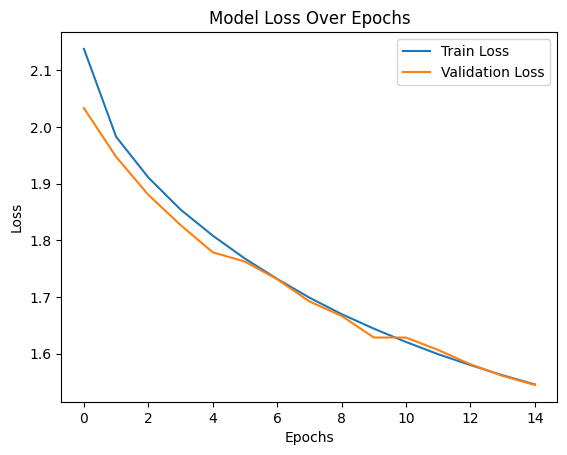

In [61]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [62]:
# After training your model
y_pred = model.predict(X_test)

57275/57275 ━━━━━━━━━━━━━━━━━━━━ 35s 602us/step


In [63]:
# print("Evaluate on test data")
# results = model.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test mae:", results)

In [64]:
# Convert y_test to NumPy array with float64 data type
y_test_np = y_test.to_numpy(dtype=np.float64)

# Ensure y_pred is a NumPy array with float64 data type
y_pred_np = np.array(y_pred, dtype=np.float64)

In [65]:
# Assuming y_test and y_pred are NumPy arrays
absolute_errors = np.abs(y_test_np - y_pred_np)
coordinate_ranges = np.ptp(y_test_np, axis=0)  # Peak to peak (max - min) along each coordinate

# Avoid division by zero
coordinate_ranges[coordinate_ranges == 0] = 1

relative_errors = absolute_errors / coordinate_ranges
mean_relative_error = np.mean(relative_errors, axis=0)

print(f"Mean Relative Error for coord1: {mean_relative_error[0]:.4f}")
print(f"Mean Relative Error for coord2: {mean_relative_error[1]:.4f}")


Mean Relative Error for coord1: 0.1840
Mean Relative Error for coord2: 0.1723


In [66]:
from scipy.stats import spearmanr

rho_coord1, _ = spearmanr(y_test_np[:, 0], y_pred_np[:, 0])
rho_coord2, _ = spearmanr(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Spearman's Rank Correlation for coord1: {rho_coord1:.4f}")
print(f"Spearman's Rank Correlation for coord2: {rho_coord2:.4f}")


Spearman's Rank Correlation for coord1: 0.6133
Spearman's Rank Correlation for coord2: 0.5687


In [67]:
# Create a mapping from coordinate pairs to class labels
unique_coords = np.unique(y_test_np, axis=0)
coord_to_label = {tuple(coord): idx for idx, coord in enumerate(unique_coords)}

# Convert coordinates to labels
y_test_labels = np.array([coord_to_label[tuple(coord)] for coord in y_test_np])
y_pred_labels = np.array([coord_to_label.get(tuple(coord), -1) for coord in y_pred_np])  # Use -1 for unknowns


In [68]:
# from sklearn.metrics import accuracy_score, confusion_matrix

# # Filter out predictions that don't map to a valid label
# valid_indices = y_pred_labels != -1
# accuracy = accuracy_score(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# print(f"Classification Accuracy: {accuracy:.4f}")


In [69]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import ConfusionMatrixDisplay

# cm = confusion_matrix(y_test_labels[valid_indices], y_pred_labels[valid_indices])
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap='Blues')
# plt.title('Confusion Matrix of Predicted vs Actual Classes')
# plt.show()

In [70]:
scaler = StandardScaler()
y_test_scaled = scaler.fit_transform(y_test_np)
y_pred_scaled = scaler.transform(y_pred_np)

# Compute Mean Squared Error on standardized data
from sklearn.metrics import mean_squared_error

mse_scaled = mean_squared_error(y_test_scaled, y_pred_scaled)
print(f"MSE on Standardized Coordinates: {mse_scaled:.4f}")


MSE on Standardized Coordinates: 0.6455


In [71]:
def custom_accuracy(y_true, y_pred, tolerance):
    # Count predictions within a certain tolerance
    correct_predictions = np.all(np.abs(y_true - y_pred) <= tolerance, axis=1)
    accuracy = np.mean(correct_predictions)
    return accuracy

tolerances = [1, 0.5, 0.1]  # Adjust based on your coordinate system

for tolerance in tolerances:
    accuracy = custom_accuracy(y_test_np, y_pred_np, tolerance)
    print(f"Accuracy within tolerance {tolerance}: {accuracy:.4f}")

accuracy = custom_accuracy(y_test_np, y_pred_np, 1)

Accuracy within tolerance 1: 0.4672
Accuracy within tolerance 0.5: 0.2847
Accuracy within tolerance 0.1: 0.0522


/home/alan-xie/Documents/Thesis/wifi_localization/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


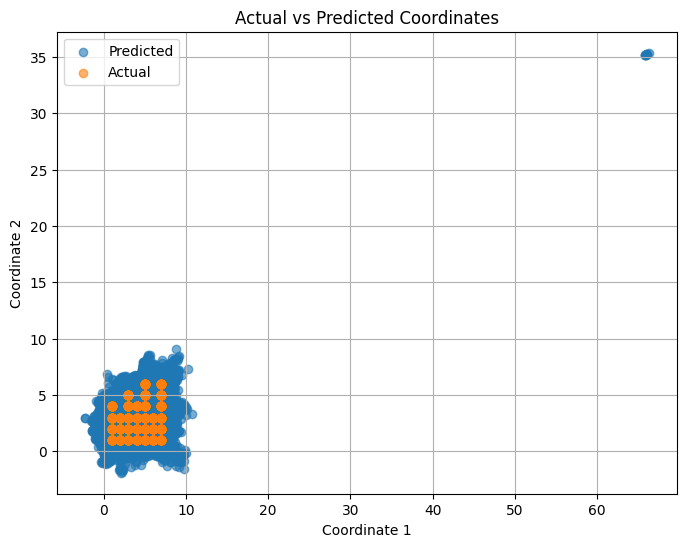

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_np[:, 0], y_pred_np[:, 1], label='Predicted', alpha=0.6)
plt.scatter(y_test_np[:, 0], y_test_np[:, 1], label='Actual', alpha=0.6)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Actual vs Predicted Coordinates')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
# MAE for each coordinate
mae_coord1 = mean_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
mae_coord2 = mean_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

# Overall MAE
mae_overall = np.mean([mae_coord1, mae_coord2])

print(f"MAE for coord1: {mae_coord1:.4f}")
print(f"MAE for coord2: {mae_coord2:.4f}")
print(f"Overall MAE: {mae_overall:.4f}")

# RMSE for each coordinate
rmse_coord1 = np.sqrt(mean_squared_error(y_test_np[:, 0], y_pred_np[:, 0]))
rmse_coord2 = np.sqrt(mean_squared_error(y_test_np[:, 1], y_pred_np[:, 1]))

# Overall RMSE
rmse_overall = np.mean([rmse_coord1, rmse_coord2])

print(f"RMSE for coord1: {rmse_coord1:.4f}")
print(f"RMSE for coord2: {rmse_coord2:.4f}")
print(f"Overall RMSE: {rmse_overall:.4f}")

# Calculate Euclidean distances
distance_errors = np.linalg.norm(y_test_np - y_pred_np, axis=1)
mean_distance_error = np.mean(distance_errors)

print(f"Mean Euclidean Distance Error: {mean_distance_error:.4f} units")

# R-squared for each coordinate
r2_coord1 = r2_score(y_test_np[:, 0], y_pred_np[:, 0])
r2_coord2 = r2_score(y_test_np[:, 1], y_pred_np[:, 1])

print(f"R-squared for coord1: {r2_coord1:.4f}")
print(f"R-squared for coord2: {r2_coord2:.4f}")

# Median Absolute Error for each coordinate
medae_coord1 = median_absolute_error(y_test_np[:, 0], y_pred_np[:, 0])
medae_coord2 = median_absolute_error(y_test_np[:, 1], y_pred_np[:, 1])

print(f"Median Absolute Error for coord1: {medae_coord1:.4f}")
print(f"Median Absolute Error for coord2: {medae_coord2:.4f}")

MAE for coord1: 1.1042
MAE for coord2: 0.8615
Overall MAE: 0.9828
RMSE for coord1: 1.5961
RMSE for coord2: 1.2190
Overall RMSE: 1.4075
Mean Euclidean Distance Error: 1.5427 units
R-squared for coord1: 0.3661
R-squared for coord2: 0.3429
Median Absolute Error for coord1: 0.7077
Median Absolute Error for coord2: 0.5970


In [74]:
# from sklearn.model_selection import KFold
# import numpy as np

# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# mae_scores = []

# for train_index, test_index in kf.split(X):
#     X_train_cv, X_test_cv = X[train_index], X[test_index]
#     y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
#     # Create and train the model
#     model = create_dnn_model(input_shape=(X_train_cv.shape[1],))
#     model.fit(X_train_cv, y_train_cv, epochs=30, batch_size=128, verbose=0)
    
#     # Evaluate the model
#     y_pred_cv = model.predict(X_test_cv)
#     mae_cv = np.mean(np.abs(y_test_cv - y_pred_cv))
#     mae_scores.append(mae_cv)

# print(f"Cross-validated MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

In [75]:
now = datetime.datetime.now()
date_time = now.strftime("%m-%d-%H-%M")

model.save(f"./models/{date_time}-{model_type}-{accuracy:.2f}.keras")